<a href="https://colab.research.google.com/github/syedirtazahaider/eyedisease/blob/master/Demo_Full_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
%cd /content/gdrive/My Drive/Project/MNet_DeepCDR

/content/gdrive/My Drive/Project/MNet_DeepCDR


In [9]:
#
from os import path
from sys import modules

import numpy as np
from keras.preprocessing import image
from matplotlib.pyplot import imshow
from pkg_resources import resource_filename
from skimage.measure import label, regionprops
from skimage.transform import rotate, resize

from mnet_deep_cdr.mnet_utils import pro_process, BW_img, disc_crop
%matplotlib inline

import cv2

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from mnet_deep_cdr import Model_DiscSeg as DiscModel
from mnet_deep_cdr import Model_MNet as MNetModel

DiscROI_size = 800
DiscSeg_size = 640
CDRSeg_size = 400

_parent_dir = r'/content/gdrive/My Drive/Project/MNet_DeepCDR/mnet_deep_cdr'
data_img_path = path.join(_parent_dir, 'test_img')

DiscSeg_model = DiscModel.DeepModel(size_set=DiscSeg_size)
DiscSeg_model_dir = path.join(_parent_dir, 'deep_model')
DiscSeg_model.load_weights(path.join(DiscSeg_model_dir, 'Model_DiscSeg_ORIGA.h5'))

CDRSeg_model = MNetModel.DeepModel(size_set=CDRSeg_size)
CDRSeg_model.load_weights(path.join(DiscSeg_model_dir, 'Model_MNet_REFUGE.h5'))

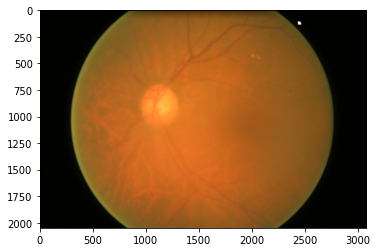

In [10]:

img_name = 'CS649_G.jpg'

org_img = np.asarray(image.load_img(path.join(data_img_path, img_name)))
imshow(org_img)

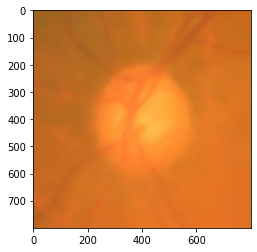

In [11]:
temp_img = resize(org_img, (DiscSeg_size, DiscSeg_size, 3))*255
temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
prob_10 = DiscSeg_model.predict([temp_img])

disc_map = BW_img(np.reshape(prob_10, (DiscSeg_size, DiscSeg_size)), 0.5)

regions = regionprops(label(disc_map))
C_x = regions[0].centroid[0] * org_img.shape[0] / DiscSeg_size
C_y = regions[0].centroid[1] * org_img.shape[1] / DiscSeg_size

disc_region, err_coord, crop_coord = disc_crop(org_img, DiscROI_size, C_x, C_y)
imshow(disc_region)

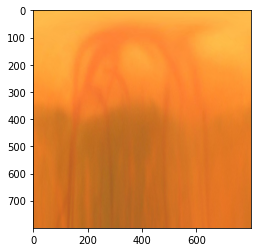

In [12]:
Disc_flat = rotate(cv2.linearPolar(disc_region, (DiscROI_size/2, DiscROI_size/2), DiscROI_size/2, cv2.WARP_FILL_OUTLIERS), -90)
imshow(Disc_flat)

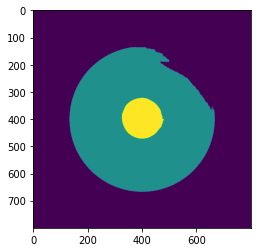

In [17]:
from skimage.transform import rotate, resize
temp_img = pro_process(Disc_flat, CDRSeg_size)
temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
[prob_6, prob_7, prob_8, prob_9, prob_10] = CDRSeg_model.predict(temp_img)
prob_map = np.reshape(prob_10, (prob_10.shape[1], prob_10.shape[2], prob_10.shape[3]))
disc_map = resize(prob_map[:, :, 0], (DiscROI_size, DiscROI_size))
cup_map = resize(prob_map[:, :, 1], (DiscROI_size, DiscROI_size))
disc_map[-round(DiscROI_size / 3):, :] = 0
cup_map[-round(DiscROI_size / 2):, :] = 0
disc_map = BW_img(disc_map, 0.5)
cup_map = BW_img(cup_map, 0.5)
De_disc_map = cv2.linearPolar(rotate(disc_map, 90), (DiscROI_size/2, DiscROI_size/2),
                              DiscROI_size/2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)
De_cup_map = cv2.linearPolar(rotate(cup_map, 90), (DiscROI_size/2, DiscROI_size/2),
                             DiscROI_size/2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)

De_disc_map = np.array(BW_img(De_disc_map, 0.5), dtype=int)
De_cup_map = np.array(BW_img(De_cup_map, 0.5), dtype=int)
ROI_result = np.array(BW_img(De_disc_map, 0.5), dtype=int) + np.array(BW_img(De_cup_map, 0.5), dtype=int)
imshow(ROI_result)

#rgbArray = np.zeros((DiscROI_size, DiscROI_size, 3))
#rgbArray[..., 0] = BW_img(De_disc_map, 0.5)
#rgbArray[..., 1] = BW_img(De_cup_map, 0.5)
#imshow(rgbArray)

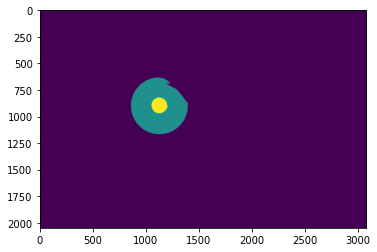

In [18]:
Img_result = np.zeros((org_img.shape[0],org_img.shape[1]), dtype=int)

Img_result[crop_coord[0]:crop_coord[1], crop_coord[2]:crop_coord[3], ] = ROI_result[err_coord[0]:err_coord[1], err_coord[2]:err_coord[3], ]

imshow(Img_result)

In [19]:
C_x

899.5604819277108